In [1]:
# Own Libraries
from utils.plotting import plot_image_and_similar
from utils.data import DataManager
from utils.metrics import prec_recall, iou_score, f1_dice
from utils.similarity import Similarity
from utils.image_processing import image_to_windows, get_3d_norm_histogram, calculate_histograms, text_removal, find_greatest_contour
from utils.denoising import denoise_images
# 3rd Party Libraries
from skimage import exposure
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import scipy.ndimage
from skimage import feature

In [2]:
data_manager = DataManager()

db, db_files = data_manager.load_data("./data/BBDD/",".jpg", desc = "Loading BBDD Data...")
qsd1_w4, qsd1_w4_files = data_manager.load_data("./data/qsd1_w4/",".jpg", desc = "Loading qsd1_w4 Data...")

Loading qsd1_w4 Data...:  27%|███████████████▍                                          | 8/30 [00:00<00:00, 51.76it/s]

./data/BBDD/ read: 287 images


Loading qsd1_w4 Data...: 100%|█████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.93it/s]


./data/qsd1_w4/ read: 30 images


In [3]:
qsd1_w4_denoised = denoise_images(qsd1_w4,method='median',ksize=(3,3))

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 199.21it/s]


In [4]:
with open("./data/qsd1_w4/text_boxes.pkl", "rb") as file:
    gt_boxes = pickle.load(file)
    print(gt_boxes)


[[[1355, 2046, 1955, 2141]], [[628, 1599, 1228, 1683]], [[391, 1199, 991, 1290]], [[624, 122, 1224, 176]], [[853, 200, 1453, 271]], [[199, 630, 799, 722], [1337, 596, 1849, 674], [2216, 198, 2653, 265]], [[167, 403, 452, 439]], [[169, 223, 574, 282]], [[621, 213, 1221, 304]], [[913, 1616, 1513, 1746]], [[169, 105, 496, 164]], [[335, 1226, 935, 1352]], [[1353, 313, 1953, 442]], [[150, 184, 508, 233]], [[1479, 1906, 2079, 2070]], [[112, 471, 357, 504], [641, 347, 935, 405], [1209, 409, 1432, 453]], [[502, 1793, 1102, 1919], [2740, 1440, 3340, 1566]], [[217, 733, 608, 827]], [[890, 1869, 1490, 1994]], [[107, 161, 376, 195]], [[1637, 259, 2237, 388]], [[927, 449, 1527, 551]], [[175, 391, 482, 453]], [[191, 145, 503, 181], [878, 110, 1327, 163]], [[580, 2131, 1180, 2211]], [[539, 246, 1139, 337]], [[194, 148, 495, 194], [686, 238, 853, 280]], [[742, 484, 1342, 550]], [[183, 172, 656, 217]], [[504, 1445, 1104, 1540], [2830, 1172, 3390, 1260]]]


In [27]:
masked,contour = text_removal(qsd1_w4,2,method='better',desc='Removing text')

Removing text: 100%|███████████████████████████████████████████████████████████████████| 30/30 [01:11<00:00,  2.39s/it]


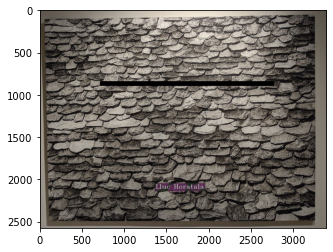

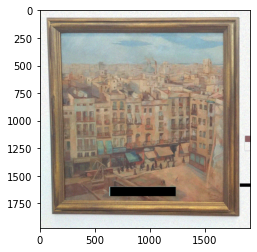

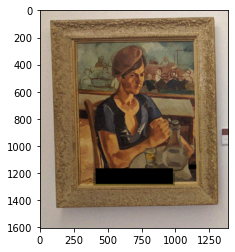

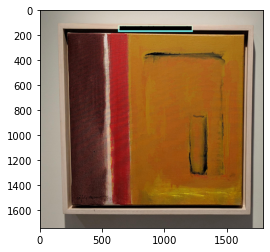

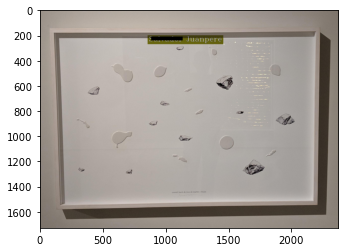

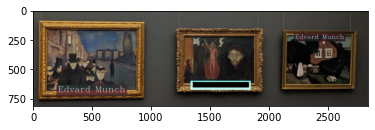

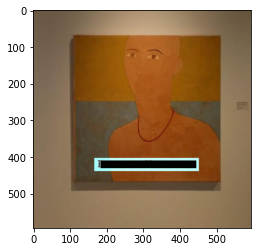

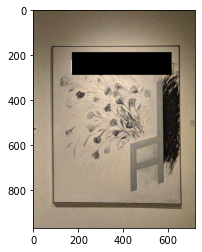

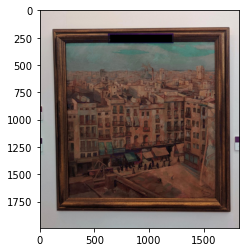

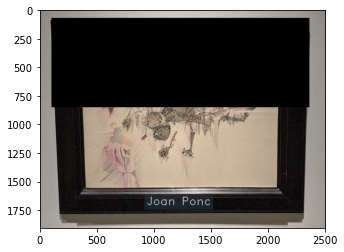

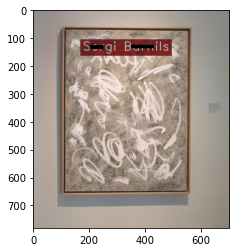

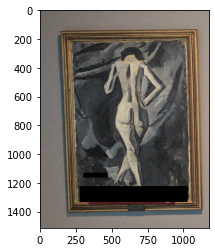

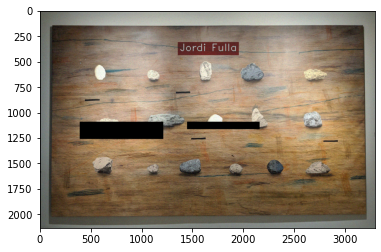

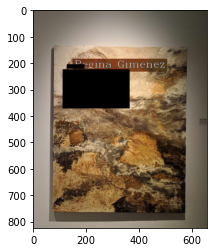

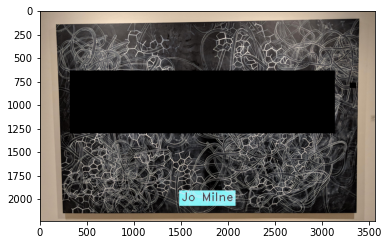

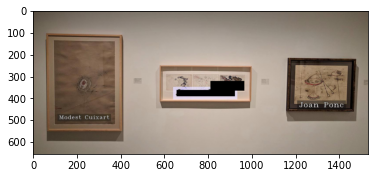

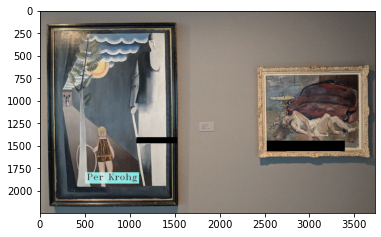

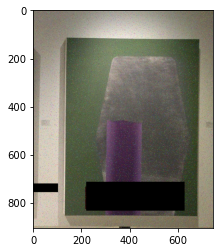

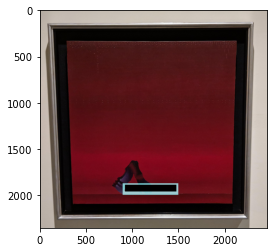

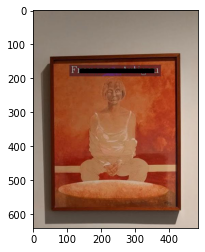

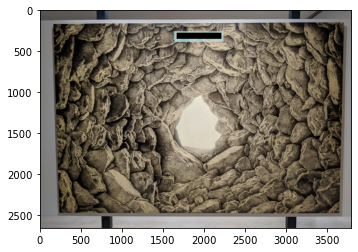

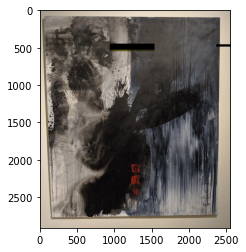

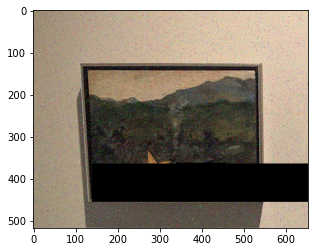

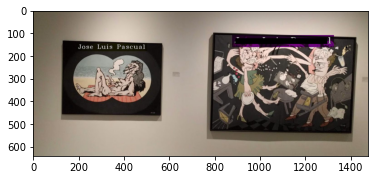

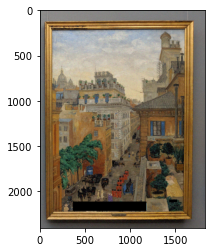

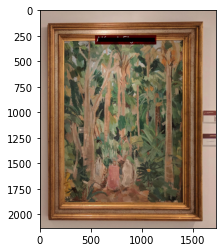

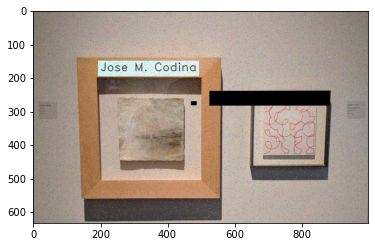

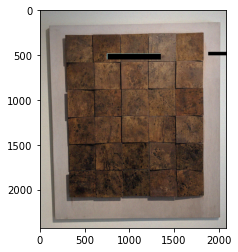

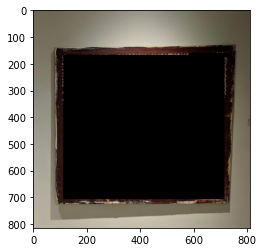

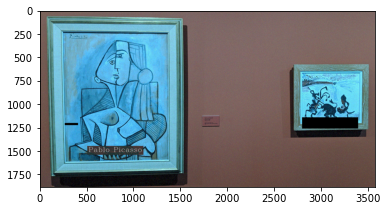

In [28]:
for i in masked:
    plt.figure()
    plt.imshow(i)
    plt.show()

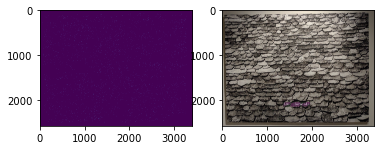

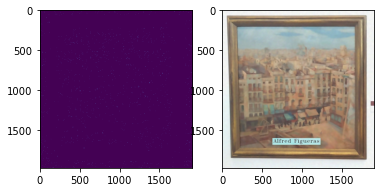

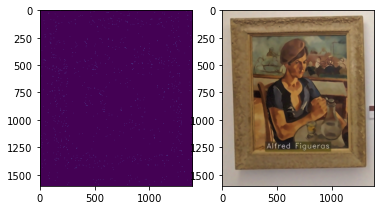

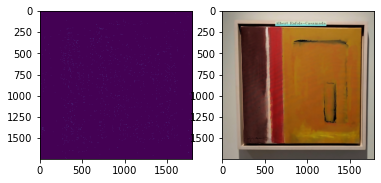

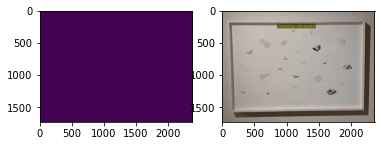

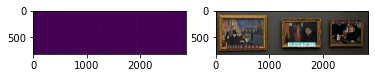

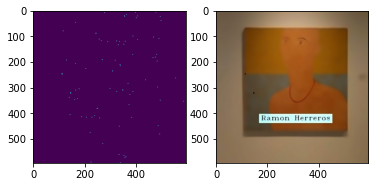

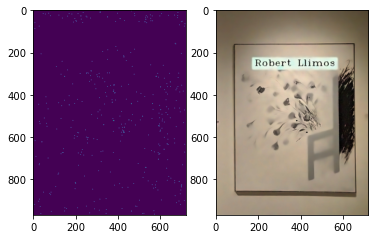

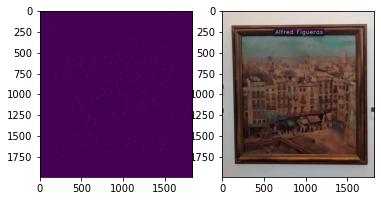

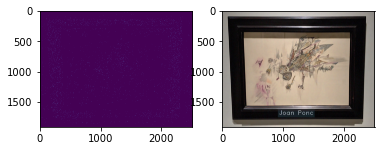

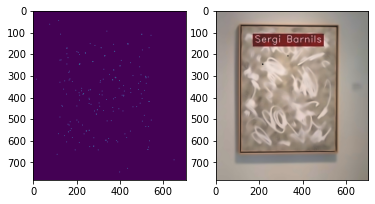

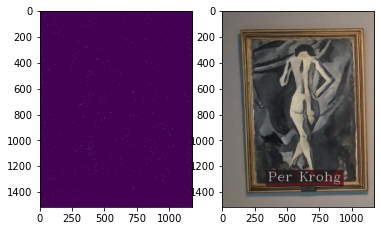

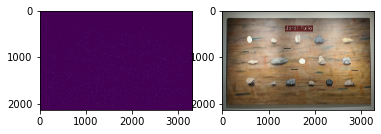

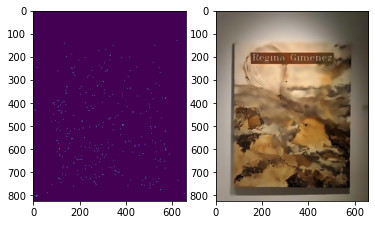

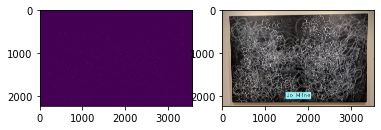

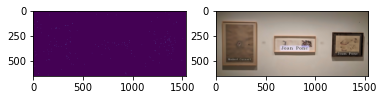

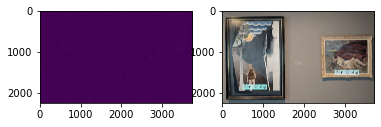

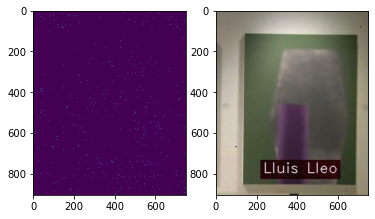

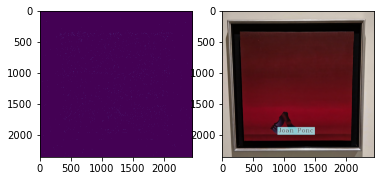

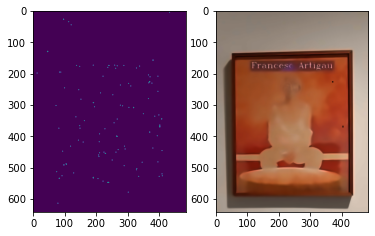

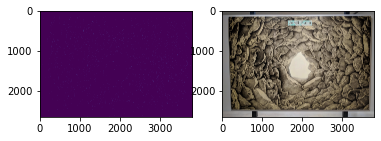

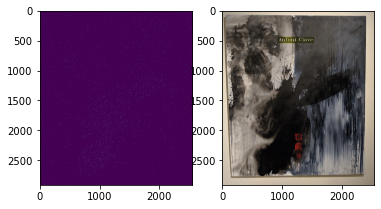

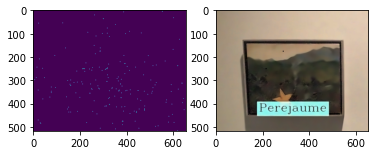

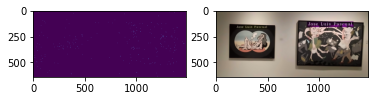

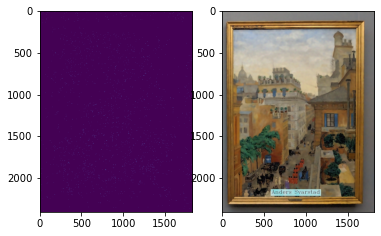

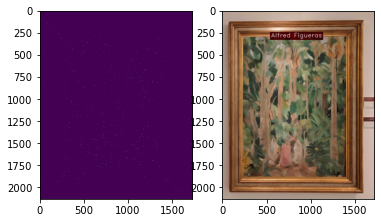

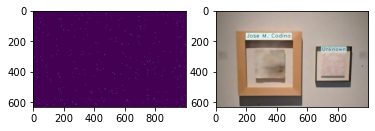

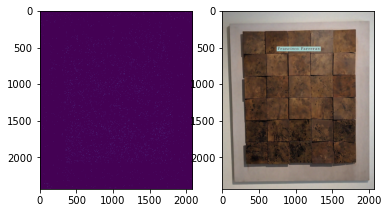

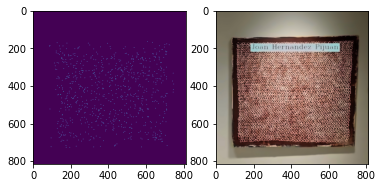

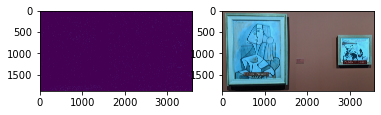

In [68]:
def morph_filter(mask, kernel, filter):
    return cv2.morphologyEx(mask, filter, np.ones(kernel, np.uint8))

for image in qsd1_w4:
    value_hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)[:,:,2]
    #Converting blacks to white and white to whites to whites
    abs_v = exposure.equalize_adapthist(value_hsv, clip_limit=0.05)
   
    """#Applying  blackhat morph operator and thresholding
    blackhat = morph_filter(abs_v,(3,3),cv2.MORPH_BLACKHAT)
    blackhat = blackhat / np.max(blackhat)
    mask = np.zeros((image.shape[0], image.shape[1]))
    mask[blackhat > 0.4] = 1
    
    mask = morph_filter(mask, (2, 10), cv2.MORPH_CLOSE)  ##Fill letter
    mask = morph_filter(mask, (4, 4),
                        cv2.MORPH_OPEN)  # Delete vetical kernel = (1,3) and horizontal lines kernel = (4,1). Total kernel = (4,3)
    mask = morph_filter(mask, (1, 29), cv2.MORPH_CLOSE)  # Join letters"""
    
    edges = feature.canny(abs_v,sigma=2,low_threshold=0.5,high_threshold=0.6,use_quantiles=True)
    coords = find_greatest_contour(mask, 2)
    im_copy = image.copy()
    rect = cv2.rectangle(im_copy, (coords[0][0],coords[0][1]),(coords[0][0]+coords[0][2],coords[0][1]+coords[0][3]) , (0,0,0), -1)
    rect = cv2.rectangle(im_copy, (coords[1][0],coords[1][1]),(coords[1][0]+coords[1][2],coords[1][1]+coords[1][3]) , (0,0,0), -1)
    plt.figure()
    plt.subplot(121)
    plt.imshow(mask)
    plt.subplot(122)
    plt.imshow(im_copy)
    plt.show()

Removing text...: 100%|████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.65it/s]


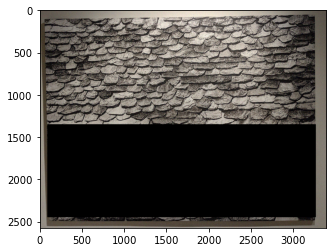

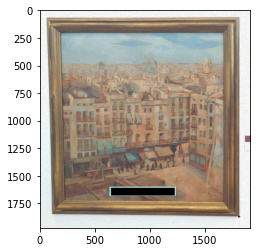

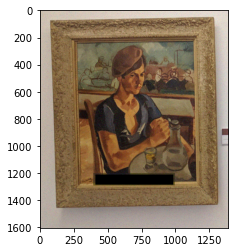

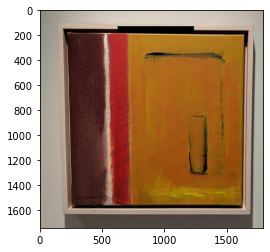

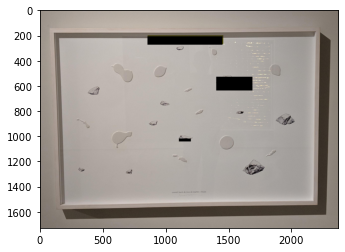

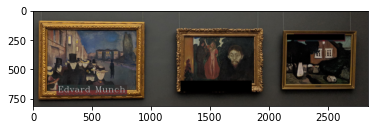

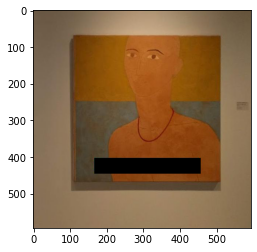

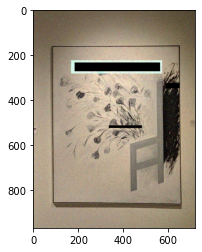

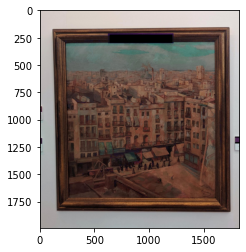

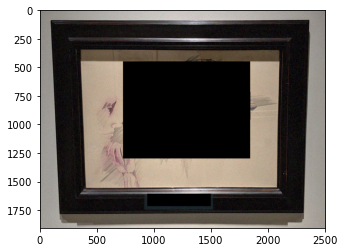

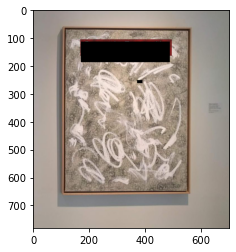

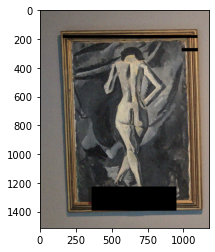

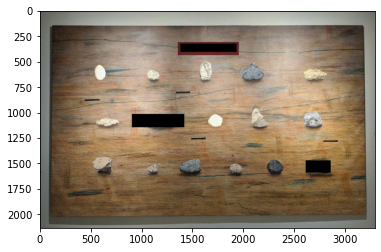

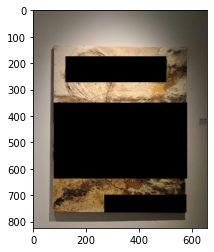

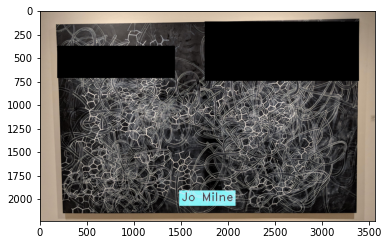

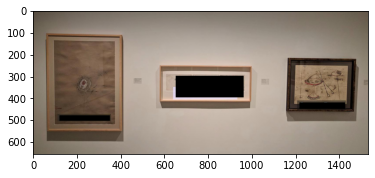

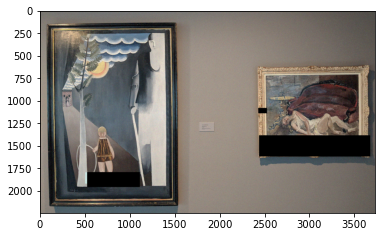

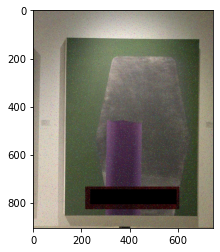

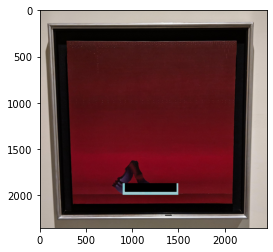

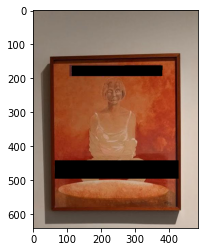

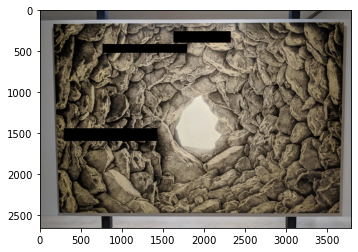

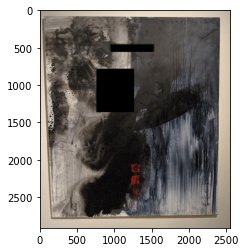

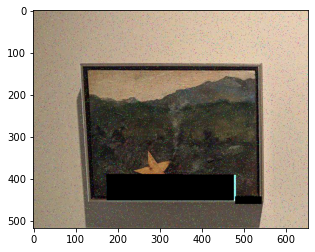

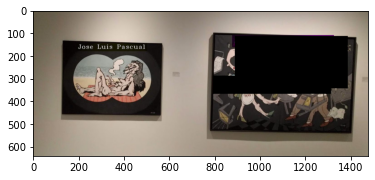

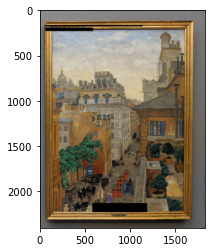

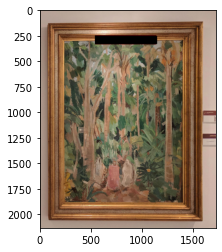

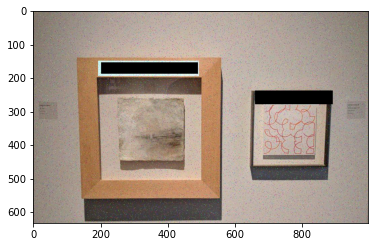

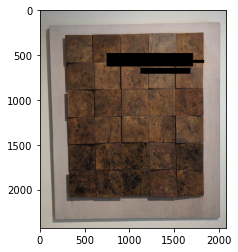

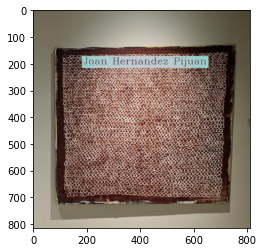

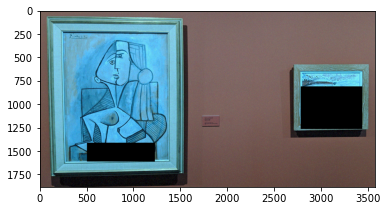

In [4]:
images, contours = text_removal(qsd1_w4,3,'transparent','Removing text...')
for i in images:
    plt.figure()
    plt.imshow(i)
    plt.show()